# DeepSurv for Battery RUL Prediction

This notebook implements a Deep Cox Proportional Hazards Model (DeepSurv) to predict the risk of battery failure.
Failure is defined as SOH dropping below a threshold (e.g., 0.7).

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

torch.manual_seed(42)
np.random.seed(42)

plt.style.use("seaborn-v0_8")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Data Loading Constants
DATA_ROOT = Path("cleaned_dataset")
META_PATH = DATA_ROOT / "metadata.csv"
FEATURE_COLS = [
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_load",
    "Voltage_load",
]
SOH_THRESHOLD = 0.75

def load_cycle_features(filename: str) -> np.ndarray:
    """Loads cycle data and extracts features (mean/std/etc)."""
    path = DATA_ROOT / "data" / filename
    df = pd.read_csv(path)
    features = []
    for col in FEATURE_COLS:
        features.extend([
            df[col].mean(),
            df[col].std(),
            df[col].min(),
            df[col].max()
        ])
    return np.array(features)
    
def prepare_survival_data(battery_ids):
    meta_df = pd.read_csv(META_PATH)
    all_X = []
    all_T = []
    all_E = []

    for battery_id in battery_ids:
        battery_meta = meta_df[(meta_df["type"] == "discharge") & (meta_df["battery_id"] == battery_id)].sort_values("start_time").reset_index(drop=True)
        battery_meta["Capacity"] = pd.to_numeric(battery_meta["Capacity"], errors="coerce")
        battery_meta["soh"] = battery_meta["Capacity"] / battery_meta["Capacity"].iloc[0]

        # Find failure cycle
        failure_idx = battery_meta[battery_meta["soh"] < SOH_THRESHOLD].index
        if len(failure_idx) > 0:
            failure_cycle = failure_idx[0]
            event = 1
        else:
            failure_cycle = len(battery_meta) - 1
            event = 0 # Censored

        # Generate samples for each cycle up to failure/end
        for t in range(len(battery_meta)):
            if t > failure_cycle: break

            # Input features
            features = load_cycle_features(battery_meta.iloc[t]["filename"])
            all_X.append(features)

            # Time to event (RUL)
            rul = failure_cycle - t
            all_T.append(rul)
            all_E.append(event)

    return np.array(all_X), np.array(all_T), np.array(all_E)

# Load Data (Train/Test Split)
TRAIN_IDS = ["B0006", "B0007", "B0018"]
TEST_IDS = ["B0005"]

print("Loading training data...")
X_train, T_train, E_train = prepare_survival_data(TRAIN_IDS)

print("Loading testing data...")
X_test, T_test, E_test = prepare_survival_data(TEST_IDS)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Loading training data...
Loading testing data...
Train shape: (301, 20), Test shape: (22, 20)


In [ ]:
class DeepSurv(nn.Module):
    """Deep Cox Proportional Hazards Model (MLP)."""
    def __init__(self, input_size, hidden_layers=[64, 32], dropout=0.1):
        super().__init__()
        layers = []
        prev_size = input_size
        for size in hidden_layers:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(size))
            layers.append(nn.Dropout(dropout))
            prev_size = size
        layers.append(nn.Linear(prev_size, 1))  # Output log-risk h(x)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def cox_ph_loss(log_risk, event, time):
    """
    Cox Partial Likelihood Loss.
    L = - sum_{i: E_i=1} (h(x_i) - log sum_{j: T_j >= T_i} exp(h(x_j)))
    """
    # 데이터를 오래 산 순서대로(시간이 큰 순서) 정렬
    idx = torch.argsort(time, descending=True)
    log_risk = log_risk[idx]
    event = event[idx]
    time = time[idx]
    
    # 특정 배터리가 죽은 시점에, "아직 살아있는 모든 배터리들"의 위험도 합계
    exp_risk = torch.exp(log_risk)
    risk_set_sum = torch.cumsum(exp_risk, dim=0)
    log_risk_set_sum = torch.log(risk_set_sum)
    
    # 발생한 event에 대해서만 loss 적용
    loss = -torch.sum(event * (log_risk - log_risk_set_sum))
    return loss / (torch.sum(event) + 1e-6)  

def c_index(risk_scores, T, E):
    """Concordance Index (C-index)."""
    n = len(T)
    concordant = 0
    permissible = 0
    for i in range(n):
        for j in range(i + 1, n):
            if T[i] != T[j]:  # Comparable pair
                # If i died before j (T_i < T_j) and E_i=1
                if T[i] < T[j] and E[i] == 1:
                    permissible += 1
                    if risk_scores[i] > risk_scores[j]:  # Higher risk should mean lower time
                        concordant += 1
                # If j died before i (T_j < T_i) and E_j=1
                elif T[j] < T[i] and E[j] == 1:
                    permissible += 1
                    if risk_scores[j] > risk_scores[i]:
                        concordant += 1
    return concordant / permissible if permissible > 0 else 0.0

In [ ]:
# Training Loop
def train_deepsurv(X, T, E, epochs=100, lr=1e-3):
    input_size = X.shape[1]
    model = DeepSurv(input_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    X_tensor = torch.from_numpy(X).float().to(device)
    T_tensor = torch.from_numpy(T).float().to(device)
    E_tensor = torch.from_numpy(E).float().to(device)

    history = {"loss": [], "c_index": []}

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        log_risk = model(X_tensor).squeeze()
        loss = cox_ph_loss(log_risk, E_tensor, T_tensor)
        loss.backward()
        optimizer.step()
        
        history["loss"].append(loss.item())

        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                risk_scores = model(X_tensor).squeeze().cpu().numpy()
                c_idx = c_index(risk_scores, T, E)
                history["c_index"].append(c_idx)
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, C-index: {c_idx:.4f}")
    
    return model, history

# Normalize Features
# 주의: 반드시 Train 데이터의 통계량(mean, std)을 사용하여 Train과 Test를 정규화해야 합니다.
mean = X_train.mean(axis=0)
std = X_train.std(axis=0) + 1e-6

X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std

# Train on Training Set
print("Start Training...")
model, history = train_deepsurv(X_train_norm, T_train, E_train, epochs=100)

# Evaluate on Test Set
model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test_norm).float().to(device)
    risk_scores_test = model(X_test_tensor).squeeze().cpu().numpy()
    c_idx_test = c_index(risk_scores_test, T_test, E_test)
    print(f"\n[Final Result] Test C-index (B0005): {c_idx_test:.4f}")

Start Training...
Epoch 10/100, Loss: 4.1439, C-index: 0.8067
Epoch 20/100, Loss: 4.0474, C-index: 0.8494
Epoch 30/100, Loss: 3.9963, C-index: 0.8655
Epoch 40/100, Loss: 3.9607, C-index: 0.8654
Epoch 50/100, Loss: 3.8607, C-index: 0.8677
Epoch 60/100, Loss: 3.8758, C-index: 0.8734
Epoch 70/100, Loss: 3.8412, C-index: 0.8755
Epoch 80/100, Loss: 3.7553, C-index: 0.8782
Epoch 90/100, Loss: 3.8186, C-index: 0.8799
Epoch 100/100, Loss: 3.7666, C-index: 0.8863

[Final Result] Test C-index (B0005): 0.5368


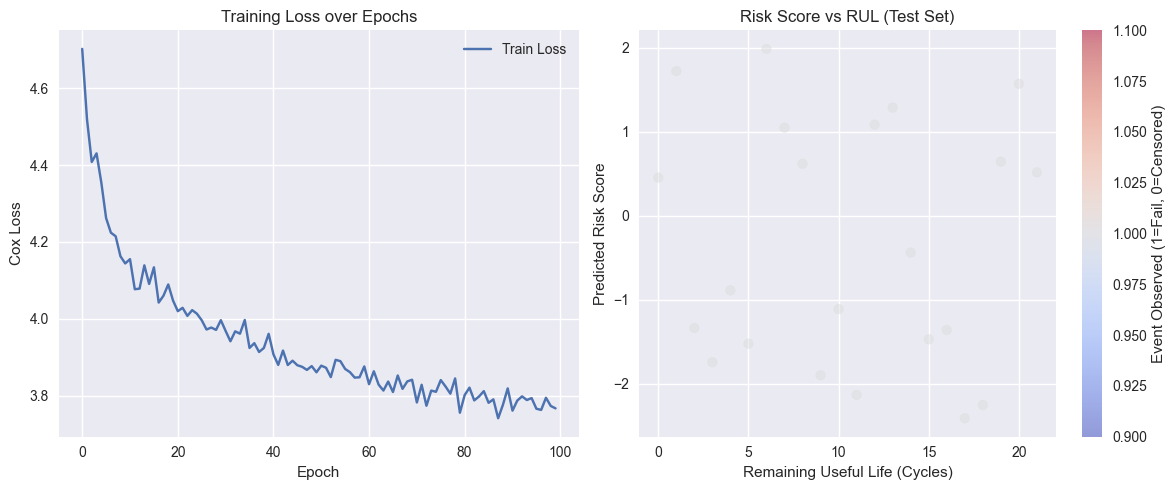

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Visualization
plt.figure(figsize=(12, 5))

# 1. Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history["loss"], label="Train Loss")

plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cox Loss")
plt.legend()

# 2. Risk Score vs Remaining Useful Life (RUL)
# 2. Risk Score vs Remaining Useful Life (RUL) - Test Data
model.eval()
with torch.no_grad():
    # 테스트 데이터에 대해 예측 수행
    X_tensor = torch.from_numpy(X_test_norm).float().to(device)
    risk_scores = model(X_tensor).squeeze().cpu().numpy()

plt.subplot(1, 2, 2)
# T_test, E_test 사용
plt.scatter(T_test, risk_scores, alpha=0.5, c=E_test, cmap="coolwarm", label="Test Data (B0018)")

plt.title("Risk Score vs RUL (Test Set)")
plt.xlabel("Remaining Useful Life (Cycles)")
plt.ylabel("Predicted Risk Score")
plt.colorbar(label="Event Observed (1=Fail, 0=Censored)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# [디버깅] B0018 데이터의 Event 값 분포 확인
print(f"Test Data (B0018) Total Samples: {len(E_test)}")
print(f"Test Data (B0018) Event=1 Count: {np.sum(E_test == 1)}")
print(f"Test Data (B0018) Event=0 Count: {np.sum(E_test == 0)}")

# 만약 Event=1인 샘플이 0개라면, 임계값을 더 높여야 합니다.
# B0018의 SOH 분포 확인
meta_df = pd.read_csv(META_PATH)
b0018_meta = meta_df[(meta_df["type"] == "discharge") & (meta_df["battery_id"] == "B0018")]
b0018_meta["Capacity"] = pd.to_numeric(b0018_meta["Capacity"], errors="coerce")
soh_values = b0018_meta["Capacity"] / b0018_meta["Capacity"].iloc[0]
print(f"B0018 SOH Range: {soh_values.min():.4f} ~ {soh_values.max():.4f}")

Test Data (B0018) Total Samples: 22
Test Data (B0018) Event=1 Count: 22
Test Data (B0018) Event=0 Count: 0
B0018 SOH Range: 0.7229 ~ 1.0000


In [ ]:
# [진단 코드] 각 배터리별 최소 SOH 및 Event 발생 여부 확인
check_ids = ["B0005", "B0006", "B0007", "B0018"]
meta_df = pd.read_csv(META_PATH)

print(f"Current SOH Threshold: {SOH_THRESHOLD}\n")
print(f"{'Battery ID':<12} | {'Min SOH':<10} | {'Event=1 Found?':<15} | {'Total Cycles':<12}")
print("-" * 60)

for bid in check_ids:
    # 1. 메타데이터 로드 및 SOH 계산
    battery_meta = meta_df[(meta_df["type"] == "discharge") & (meta_df["battery_id"] == bid)].sort_values("start_time")
    battery_meta["Capacity"] = pd.to_numeric(battery_meta["Capacity"], errors="coerce")
    
    if len(battery_meta) == 0:
        print(f"{bid:<12} | {'No Data':<10} | {'-':<15} | {0:<12}")
        continue

    initial_capacity = battery_meta["Capacity"].iloc[0]
    soh_values = battery_meta["Capacity"] / initial_capacity
    min_soh = soh_values.min()
    
    # 2. Event 발생 여부 확인 (현재 Threshold 기준)
    # SOH가 Threshold보다 작은 지점이 하나라도 있으면 Event=1
    has_failure = (soh_values < SOH_THRESHOLD).any()
    
    print(f"{bid:<12} | {min_soh:.4f}     | {str(has_failure):<15} | {len(battery_meta):<12}")

print("-" * 60)

Current SOH Threshold: 0.75

Battery ID   | Min SOH    | Event=1 Found?  | Total Cycles
------------------------------------------------------------
B0005        | 0.7052     | True            | 168         
B0006        | 0.5996     | True            | 168         
B0007        | 0.7485     | True            | 168         
B0018        | 0.7647     | False           | 132         
------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np

# 이미지에 있는 모든 배터리 ID 리스트
ALL_BATTERY_IDS = [
    # Group 1
    "B0005", "B0006", "B0007", "B0018",
    # Group 2
    "B0025", "B0026", "B0027", "B0028",
    # Group 3
    "B0029", "B0030", "B0031", "B0032",
    # Group 4
    "B0033", "B0034", "B0036",
    # Group 5
    "B0038", "B0039", "B0040",
    # Group 6
    "B0041", "B0042", "B0043", "B0044",
    # Group 7
    "B0045", "B0046", "B0047", "B0048",
    # Group 8
    "B0049", "B0050", "B0051", "B0052",
    # Group 9
    "B0053", "B0054", "B0055", "B0056"
]

meta_df = pd.read_csv(META_PATH)

print(f"{'Battery ID':<12} | {'Min SOH':<10} | {'Cycles':<10} | {'Status'}")
print("-" * 50)

valid_ids = []
min_soh_list = []

for bid in ALL_BATTERY_IDS:
    try:
        # 메타데이터 필터링
        battery_meta = meta_df[(meta_df["type"] == "discharge") & (meta_df["battery_id"] == bid)].sort_values("start_time")
        
        if len(battery_meta) == 0:
            print(f"{bid:<12} | {'No Data':<10} | {0:<10} | Skip")
            continue

        battery_meta["Capacity"] = pd.to_numeric(battery_meta["Capacity"], errors="coerce")
        
        # 초기 용량 대비 현재 용량 (SOH)
        initial_capacity = battery_meta["Capacity"].iloc[0]
        soh_values = battery_meta["Capacity"] / initial_capacity
        min_soh = soh_values.min()
        
        print(f"{bid:<12} | {min_soh:.4f}     | {len(battery_meta):<10} | OK")
        
        valid_ids.append(bid)
        min_soh_list.append(min_soh)
        
    except Exception as e:
        print(f"{bid:<12} | {'Error':<10} | {0:<10} | {str(e)}")

print("-" * 50)
print(f"Total Valid Batteries: {len(valid_ids)}")
print(f"Average Min SOH: {np.mean(min_soh_list):.4f}")
print(f"Global Min SOH: {np.min(min_soh_list):.4f}")
print(f"Global Max of Min SOH: {np.max(min_soh_list):.4f}")

Battery ID   | Min SOH    | Cycles     | Status
--------------------------------------------------
B0005        | 0.7052     | 168        | OK
B0006        | 0.5996     | 168        | OK
B0007        | 0.7485     | 168        | OK
B0018        | 0.7647     | 132        | OK
B0025        | 0.9571     | 28         | OK
B0026        | 0.7646     | 28         | OK
B0027        | 0.9708     | 28         | OK
B0028        | 0.9515     | 28         | OK
B0029        | 0.9269     | 40         | OK
B0030        | 0.9348     | 40         | OK
B0031        | 0.9514     | 40         | OK
B0032        | 0.9242     | 40         | OK
B0033        | 0.0992     | 197        | OK
B0034        | 0.4487     | 197        | OK
B0036        | 0.5563     | 197        | OK
B0038        | 0.5028     | 47         | OK
B0039        | 0.0672     | 47         | OK
B0040        | 0.2457     | 47         | OK
B0041        | 0.9440     | 67         | OK
B0042        | 0.0000     | 112        | OK
B0043        | 0.0000

# 전체 데이터에 대해 진행

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

plt.style.use("seaborn-v0_8")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Data Loading Constants
DATA_ROOT = Path("cleaned_dataset")
META_PATH = DATA_ROOT / "metadata.csv"
FEATURE_COLS = [
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_load",
    "Voltage_load",
]

# 전략: 경계선에 있는 배터리(0.7~0.8)도 고장으로 학습시키기 위해 임계값 상향
SOH_THRESHOLD = 0.70
def load_cycle_features(filename: str) -> np.ndarray:
    """Loads cycle data and extracts features (mean/std/etc)."""
    path = DATA_ROOT / "data" / filename
    df = pd.read_csv(path)
    features = []
    for col in FEATURE_COLS:
        features.extend([
            df[col].mean(),
            df[col].std(),
            df[col].min(),
            df[col].max()
        ])
    return np.array(features)
    
def prepare_survival_data(battery_ids):
    meta_df = pd.read_csv(META_PATH)
    all_X = []
    all_T = []
    all_E = []

    for battery_id in battery_ids:
        # 해당 배터리 데이터 로드
        battery_meta = meta_df[(meta_df["type"] == "discharge") & (meta_df["battery_id"] == battery_id)].sort_values("start_time").reset_index(drop=True)
        
        if len(battery_meta) == 0: continue

        battery_meta["Capacity"] = pd.to_numeric(battery_meta["Capacity"], errors="coerce")
        initial_capacity = battery_meta["Capacity"].iloc[0]
        battery_meta["soh"] = battery_meta["Capacity"] / initial_capacity

        # Find failure cycle
        failure_idx = battery_meta[battery_meta["soh"] < SOH_THRESHOLD].index
        if len(failure_idx) > 0:
            failure_cycle = failure_idx[0]
            event = 1
        else:
            failure_cycle = len(battery_meta) - 1
            event = 0 # Censored (실험 끝날 때까지 0.8 밑으로 안 떨어짐)

        # Generate samples
        for t in range(len(battery_meta)):
            # 고장 시점 이후 데이터는 사용하지 않음 (Survival Analysis 원칙)
            if t > failure_cycle: break

            try:
                features = load_cycle_features(battery_meta.iloc[t]["filename"])
                all_X.append(features)
                
                # RUL (Time to Event)
                rul = failure_cycle - t
                all_T.append(rul)
                all_E.append(event)
            except Exception as e:
                print(f"Error loading {battery_id} cycle {t}: {e}")
                continue

    return np.array(all_X), np.array(all_T), np.array(all_E)

In [ ]:
# ...existing code...
# 1. 선별된 배터리 ID 리스트 (Data Curation)
# 너무 수명이 짧거나(50사이클 미만), 실험 조건이 너무 다른 배터리는 제외하여
# 모델이 일관된 패턴을 학습하도록 유도합니다.
SELECTED_BATTERY_IDS = [
    # Group 1 (Standard, ~160 cycles) - 가장 품질이 좋음
    "B0005", "B0006", "B0007", "B0018",
    
    # Group 3 & 4 (Long life, ~100-200 cycles)
    "B0033", "B0034", "B0036",
    
    # Group 6 (Medium life, ~100 cycles)
    "B0041", "B0042", "B0043", "B0044",
    
    # Group 9 (Mixed, ~100 cycles)
    "B0053", "B0054", "B0055", "B0056"
]

# 제외된 그룹:
# B0025~32: 실험이 너무 일찍 중단됨 (Censored가 너무 많음)
# B0038~40, B0045~52: 수명이 너무 짧음 (<50 cycles) -> 노이즈로 작용

print(f"Selected Batteries: {len(SELECTED_BATTERY_IDS)}")

# 2. 배터리 단위로 Train/Test 분리 (80% Train, 20% Test)
train_ids, test_ids = train_test_split(SELECTED_BATTERY_IDS, test_size=0.2, random_state=42)

print(f"Train IDs ({len(train_ids)}): {train_ids}")
print(f"Test IDs ({len(test_ids)}): {test_ids}")

# 3. 데이터 로드
print("\nLoading Training Data...")
X_train, T_train, E_train = prepare_survival_data(train_ids)

print("Loading Testing Data...")
X_test, T_test, E_test = prepare_survival_data(test_ids)

# 4. 정규화 (Train 통계량 기준)
mean = X_train.mean(axis=0)
std = X_train.std(axis=0) + 1e-6

X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std

print(f"\nFinal Data Shapes:")
print(f"Train: X={X_train_norm.shape}, E=1 count={np.sum(E_train)}")
print(f"Test : X={X_test_norm.shape}, E=1 count={np.sum(E_test)}")
# ...existing code...
    

Selected Batteries: 15
Train IDs (12): ['B0055', 'B0034', 'B0042', 'B0007', 'B0006', 'B0056', 'B0033', 'B0041', 'B0044', 'B0054', 'B0018', 'B0036']
Test IDs (3): ['B0043', 'B0053', 'B0005']

Loading Training Data...
Loading Testing Data...

Final Data Shapes:
Train: X=(930, 20), E=1 count=461
Test : X=(318, 20), E=1 count=150


In [ ]:
class DeepSurv(nn.Module):
    """Deep Cox Proportional Hazards Model with Improvements."""
    def __init__(self, input_size, hidden_layers=[64, 32], dropout=0.4):
        super().__init__()
        layers = []
        prev_size = input_size
        for size in hidden_layers:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.SELU()) # SELU Activation for self-normalization
            layers.append(nn.BatchNorm1d(size))
            layers.append(nn.Dropout(dropout))
            prev_size = size
        layers.append(nn.Linear(prev_size, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def cox_ph_loss(log_risk, event, time):
    idx = torch.argsort(time, descending=True)
    log_risk = log_risk[idx]
    event = event[idx]
    time = time[idx]
    
    exp_risk = torch.exp(log_risk)
    risk_set_sum = torch.cumsum(exp_risk, dim=0)
    log_risk_set_sum = torch.log(risk_set_sum)
    
    loss = -torch.sum(event * (log_risk - log_risk_set_sum))
    return loss / (torch.sum(event) + 1e-6)

def c_index(risk_scores, T, E):
    n = len(T)
    concordant = 0
    permissible = 0
    for i in range(n):
        for j in range(i + 1, n):
            if T[i] != T[j]:
                if T[i] < T[j] and E[i] == 1:
                    permissible += 1
                    if risk_scores[i] > risk_scores[j]: concordant += 1
                elif T[j] < T[i] and E[j] == 1:
                    permissible += 1
                    if risk_scores[j] > risk_scores[i]: concordant += 1
    return concordant / permissible if permissible > 0 else 0.0

In [ ]:
def train_deepsurv(X, T, E, epochs=150, lr=1e-3):
    input_size = X.shape[1]
    model = DeepSurv(input_size).to(device)
    
    # Weight Decay 추가
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    # Scheduler 추가
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

    X_tensor = torch.from_numpy(X).float().to(device)
    T_tensor = torch.from_numpy(T).float().to(device)
    E_tensor = torch.from_numpy(E).float().to(device)

    history = {"loss": [], "c_index": []}

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Noise Injection (Data Augmentation)
        noise = torch.randn_like(X_tensor) * 0.05
        X_augmented = X_tensor + noise
        
        log_risk = model(X_augmented).squeeze()
        loss = cox_ph_loss(log_risk, E_tensor, T_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        history["loss"].append(loss.item())

        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                risk_scores = model(X_tensor).squeeze().cpu().numpy()
                c_idx = c_index(risk_scores, T, E)
                history["c_index"].append(c_idx)
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, C-index: {c_idx:.4f}")
    
    return model, history

# 학습 시작
print("Start Training with Augmented Data...")
model, history = train_deepsurv(X_train_norm, T_train, E_train, epochs=150)

Start Training with Augmented Data...
Epoch 10/150, Loss: 6.0237, C-index: 0.7391
Epoch 20/150, Loss: 5.8569, C-index: 0.7791
Epoch 30/150, Loss: 5.7943, C-index: 0.7916
Epoch 40/150, Loss: 5.7454, C-index: 0.7940
Epoch 50/150, Loss: 5.6756, C-index: 0.7974
Epoch 60/150, Loss: 5.7667, C-index: 0.8009
Epoch 70/150, Loss: 5.7102, C-index: 0.8016
Epoch 80/150, Loss: 5.7027, C-index: 0.8021
Epoch 90/150, Loss: 5.7279, C-index: 0.8024
Epoch 100/150, Loss: 5.7096, C-index: 0.8030
Epoch 110/150, Loss: 5.5960, C-index: 0.8038
Epoch 120/150, Loss: 5.6475, C-index: 0.8041
Epoch 130/150, Loss: 5.6777, C-index: 0.8042
Epoch 140/150, Loss: 5.6868, C-index: 0.8043
Epoch 150/150, Loss: 5.6739, C-index: 0.8043



[Final Result] Test C-index (7 Batteries): 0.7834

[Final Result] Test C-index (7 Batteries): 0.7834


<module 'matplotlib.pyplot' from 'c:\\Users\\daeho\\anaconda3\\envs\\EDA\\lib\\site-packages\\matplotlib\\pyplot.py'>

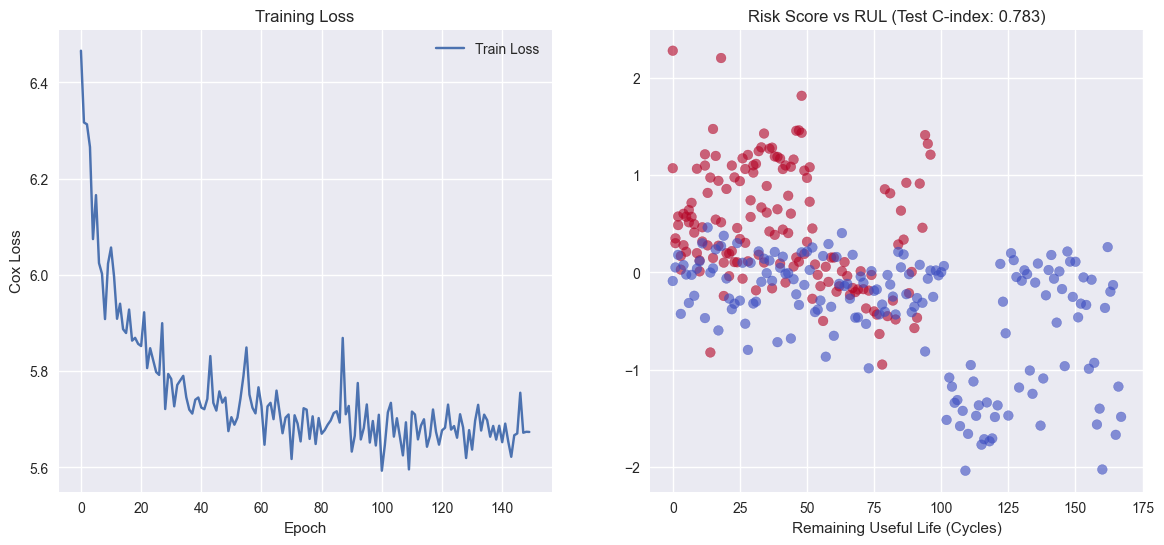

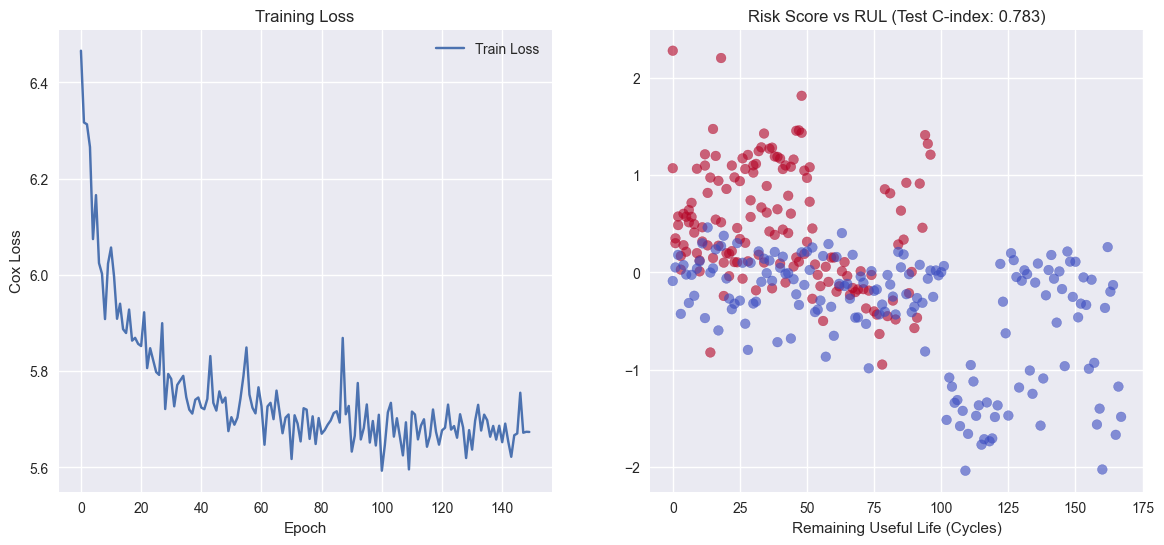

In [ ]:
# Evaluate on Test Set
model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test_norm).float().to(device)
    risk_scores_test = model(X_test_tensor).squeeze().cpu().numpy()
    c_idx_test = c_index(risk_scores_test, T_test, E_test)
    print(f"\n[Final Result] Test C-index (7 Batteries): {c_idx_test:.4f}")

# Visualization
plt.figure(figsize=(14, 6))

# 1. Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history["loss"], label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Cox Loss")
plt.legend()

# 2. Risk Score vs RUL
plt.subplot(1, 2, 2)
plt.scatter(T_test, risk_scores_test, alpha=0.6, c=E_test, cmap="coolwarm", label="Test Data")
plt.title(f"Risk Score vs RUL (Test C-index: {c_idx_test:.3f})")
plt.xlabel("Remaining Useful Life (Cycles)")
plt# Evaluate on Test Set
model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test_norm).float().to(device)
    risk_scores_test = model(X_test_tensor).squeeze().cpu().numpy()
    c_idx_test = c_index(risk_scores_test, T_test, E_test)
    print(f"\n[Final Result] Test C-index (7 Batteries): {c_idx_test:.4f}")

# Visualization
plt.figure(figsize=(14, 6))

# 1. Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history["loss"], label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Cox Loss")
plt.legend()

# 2. Risk Score vs RUL
plt.subplot(1, 2, 2)
plt.scatter(T_test, risk_scores_test, alpha=0.6, c=E_test, cmap="coolwarm", label="Test Data")
plt.title(f"Risk Score vs RUL (Test C-index: {c_idx_test:.3f})")
plt.xlabel("Remaining Useful Life (Cycles)")
plt